<a href="https://colab.research.google.com/github/pachterlab/COVID19-LA-County/blob/master/LA_County_Triggers.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#@title Install packages
%%capture
!pip install matplotlib
!pip install scikit-learn
!pip install numpy
!pip install scipy
import numpy as np
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import matplotlib.colors as mplcol
import matplotlib.font_manager
import matplotlib as mpl
import pandas as pd
import io
import json
import datetime as dt

from scipy.stats import binom
from scipy.stats import poisson
from scipy.sparse import csr_matrix
from scipy.io import mmread

from IPython.display import HTML
from mizani.breaks import date_breaks
from mizani.formatters import date_format
# Only pandas >= v0.25.0 supports column names with spaces in querys
import plotnine as p
import requests
import warnings
import colorsys
warnings.filterwarnings("ignore")  # plotnine has a lot of MatplotlibDeprecationWarning's
import seaborn as sns
sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2.5})

fsize=20

plt.rcParams.update({'font.size': fsize})
%config InlineBackend.figure_format = 'retina'

In [ ]:
!curl 'https://lacdph.shinyapps.io/covid19_surveillance_dashboard/_w_302b6a24/session/e353f957cc2ea4fa476bd2e3c7fdbb39/dataobj/tests_combo_table?w=302b6a24&nonce=35ec0ab1f917a64c' \
  -H 'authority: lacdph.shinyapps.io' \
  -H 'accept: application/json, text/javascript, */*; q=0.01' \
  -H 'x-requested-with: XMLHttpRequest' \
  -H 'user-agent: Mozilla/5.0 (Macintosh; Intel Mac OS X 10_16_0) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/84.0.4147.135 Safari/537.36' \
  -H 'content-type: application/x-www-form-urlencoded; charset=UTF-8' \
  -H 'origin: https://lacdph.shinyapps.io' \
  -H 'sec-fetch-site: same-origin' \
  -H 'sec-fetch-mode: cors' \
  -H 'sec-fetch-dest: empty' \
  -H 'referer: https://lacdph.shinyapps.io/covid19_surveillance_dashboard/' \
  -H 'accept-language: en-US,en;q=0.9' \
  -H 'cookie: session=bHVjaWQtcHJvZHVjdGlvbi1sZWdhY3ktYXBwczMzLmxwMDE6NTc1MTY%3d' \
  --data-raw 'draw=2&columns%5B0%5D%5Bdata%5D=0&columns%5B0%5D%5Bname%5D=&columns%5B0%5D%5Bsearchable%5D=true&columns%5B0%5D%5Borderable%5D=false&columns%5B0%5D%5Bsearch%5D%5Bvalue%5D=&columns%5B0%5D%5Bsearch%5D%5Bregex%5D=false&columns%5B1%5D%5Bdata%5D=1&columns%5B1%5D%5Bname%5D=&columns%5B1%5D%5Bsearchable%5D=true&columns%5B1%5D%5Borderable%5D=true&columns%5B1%5D%5Bsearch%5D%5Bvalue%5D=&columns%5B1%5D%5Bsearch%5D%5Bregex%5D=false&columns%5B2%5D%5Bdata%5D=2&columns%5B2%5D%5Bname%5D=&columns%5B2%5D%5Bsearchable%5D=true&columns%5B2%5D%5Borderable%5D=true&columns%5B2%5D%5Bsearch%5D%5Bvalue%5D=&columns%5B2%5D%5Bsearch%5D%5Bregex%5D=false&columns%5B3%5D%5Bdata%5D=3&columns%5B3%5D%5Bname%5D=&columns%5B3%5D%5Bsearchable%5D=true&columns%5B3%5D%5Borderable%5D=true&columns%5B3%5D%5Bsearch%5D%5Bvalue%5D=&columns%5B3%5D%5Bsearch%5D%5Bregex%5D=false&columns%5B4%5D%5Bdata%5D=4&columns%5B4%5D%5Bname%5D=&columns%5B4%5D%5Bsearchable%5D=true&columns%5B4%5D%5Borderable%5D=true&columns%5B4%5D%5Bsearch%5D%5Bvalue%5D=&columns%5B4%5D%5Bsearch%5D%5Bregex%5D=false&columns%5B5%5D%5Bdata%5D=5&columns%5B5%5D%5Bname%5D=&columns%5B5%5D%5Bsearchable%5D=true&columns%5B5%5D%5Borderable%5D=true&columns%5B5%5D%5Bsearch%5D%5Bvalue%5D=&columns%5B5%5D%5Bsearch%5D%5Bregex%5D=false&columns%5B6%5D%5Bdata%5D=6&columns%5B6%5D%5Bname%5D=&columns%5B6%5D%5Bsearchable%5D=true&columns%5B6%5D%5Borderable%5D=true&columns%5B6%5D%5Bsearch%5D%5Bvalue%5D=&columns%5B6%5D%5Bsearch%5D%5Bregex%5D=false&columns%5B7%5D%5Bdata%5D=7&columns%5B7%5D%5Bname%5D=&columns%5B7%5D%5Bsearchable%5D=true&columns%5B7%5D%5Borderable%5D=true&columns%5B7%5D%5Bsearch%5D%5Bvalue%5D=&columns%5B7%5D%5Bsearch%5D%5Bregex%5D=false&columns%5B8%5D%5Bdata%5D=8&columns%5B8%5D%5Bname%5D=&columns%5B8%5D%5Bsearchable%5D=true&columns%5B8%5D%5Borderable%5D=true&columns%5B8%5D%5Bsearch%5D%5Bvalue%5D=&columns%5B8%5D%5Bsearch%5D%5Bregex%5D=false&columns%5B9%5D%5Bdata%5D=9&columns%5B9%5D%5Bname%5D=&columns%5B9%5D%5Bsearchable%5D=true&columns%5B9%5D%5Borderable%5D=true&columns%5B9%5D%5Bsearch%5D%5Bvalue%5D=&columns%5B9%5D%5Bsearch%5D%5Bregex%5D=false&columns%5B10%5D%5Bdata%5D=10&columns%5B10%5D%5Bname%5D=&columns%5B10%5D%5Bsearchable%5D=true&columns%5B10%5D%5Borderable%5D=true&columns%5B10%5D%5Bsearch%5D%5Bvalue%5D=&columns%5B10%5D%5Bsearch%5D%5Bregex%5D=false&start=0&length=-1&search%5Bvalue%5D=&search%5Bregex%5D=false&search%5BcaseInsensitive%5D=true&search%5Bsmart%5D=true&escape=true' \
  --compressed > data.json

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  8261    0  5841  100  2420   7310   3028 --:--:-- --:--:-- --:--:-- 10326


In [ ]:
with open('data.json') as f:
  data = json.load(f)

In [ ]:
pop = 10_039_107
norm = 100_000
time_delta = 14 # days ie 2 weeks
cols = ["idx", "Date", "Cumulative Tests", "Cumulative Positive Tests", "Cumulative % Positive Tests", "Daily Tests", "Daily Positive Tests", "% Daily Positive Tests","7 Day Avg. Daily Tests", "7 Day Avg. Positive Tests", "7 Day Avg. Daily % Positive Tests"]
df = pd.DataFrame(data["data"], columns=cols)
df = df.set_index(pd.to_datetime(df.Date.values)).sort_index()

In [ ]:
df.head()

,idx,Date,Cumulative Tests,Cumulative Positive Tests,Cumulative % Positive Tests,Daily Tests,Daily Positive Tests,% Daily Positive Tests,7 Day Avg. Daily Tests,7 Day Avg. Positive Tests,7 Day Avg. Daily % Positive Tests
2020-03-10,172,2020-03-10,186,28,15.1%,186,28,15.1%,NaN,NaN,NA%
2020-03-11,171,2020-03-11,455,51,11.2%,269,23,8.6%,NaN,NaN,NA%
2020-03-12,170,2020-03-12,1153,140,12.1%,698,89,12.8%,NaN,NaN,NA%
2020-03-13,169,2020-03-13,2105,259,12.3%,952,119,12.5%,NaN,NaN,NA%
2020-03-14,168,2020-03-14,2827,352,12.5%,722,93,12.9%,NaN,NaN,NA%


In [ ]:
data = (df["Daily Positive Tests"].rolling(window="14d").sum()/pop*norm)[time_delta:]

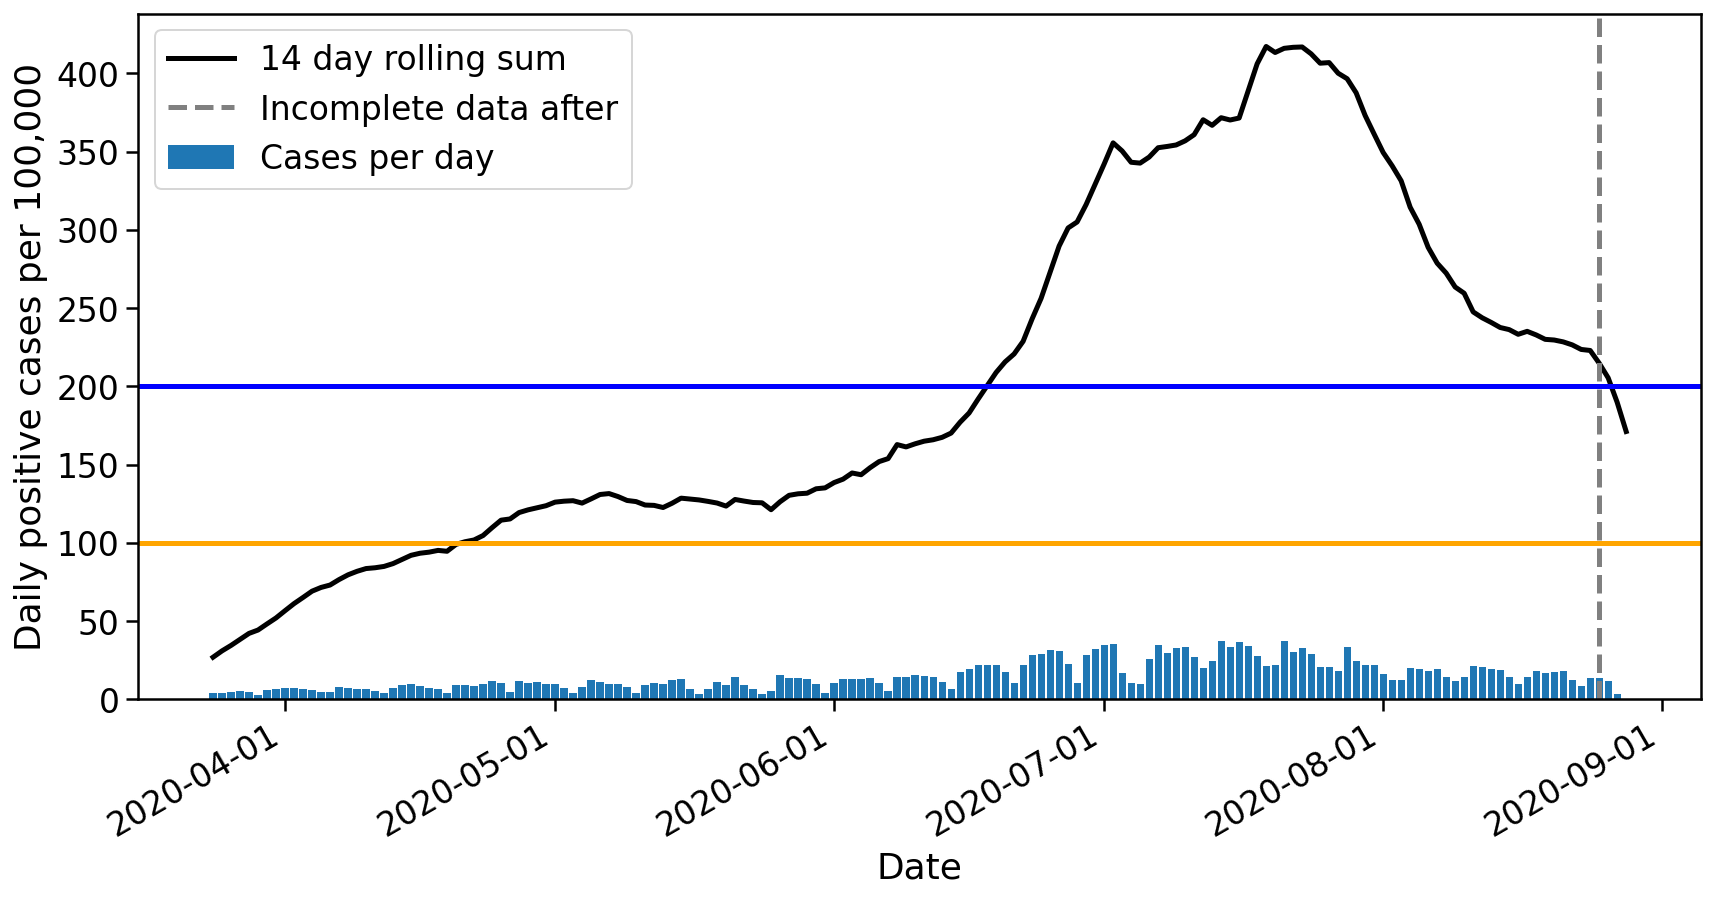

In [ ]:
#@title LA County Threshold for Schools

fig, ax = plt.subplots(figsize=(14, 7))

x = data.index.astype('O')
y = data.values

yy = (df["Daily Positive Tests"].values/pop*norm)[time_delta:]
xx = df.index.max() - dt.timedelta(days=3)

ax.plot(x,  y, color="k", label="14 day rolling sum")
ax.bar(x, yy, label="Cases per day")
ax.axhline(y=200, color="blue")
ax.axhline(y=100, color="orange")
ax.axvline(x=xx, label="Incomplete data after", color="grey", linestyle="--")

kwd = {
    "xlabel": "Date",
    "ylabel" : "Daily positive cases per 100,000"
}

myFmt = mpl.dates.DateFormatter('%Y-%m-%d')
ax.xaxis.set_major_formatter(myFmt)

## Rotate date labels automatically
fig.autofmt_xdate()

ax.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))
ax.set(**kwd)
ax.legend()

fig.show()